# It's Gettin' Hot In Herre
### Temperature Predictions of Amazonas, Brazil 


Report by: Jason Tellez

Date: 2021-10-08

---
**Goal**

Using [repackaged data](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) gathered by [Berkeley Earth](http://berkeleyearth.org/about/), the purpose of this report is to predict the average temperature of a given area. For this report, I chose to analyze the data of Amazonas, a state in Brazil which is almost entirely comprised of rainforest. I decided to go with Amazonas because of the controvesrial deforestation that has taken place since the 1970s.

---
**Executive Summary**
Models used:
- Simple Average
- Moving Average
- Holt's Linear Trend
- Previous Cycle
    
Findings:
- During the explore phase, I found that the average temperature is steadilty increasing
- Moving Average (3-month and 5-year) and Holts' Linear Trend performed similarly
- Holt's Linear Trend performed the best overall
- Ultimately Holt's Linear Trend did not perform well

|RMSE|avg_temp|avg_uncertainty|
|----|----|----|
|Validate|0.5079|0.1513|
|Test|0.58607|0.11292|

---
**Acquire:** I will acquire the data from the website and read the csv to a dataframe using pandas. Then I will look at the dataframes characteristics and move on to the prep phase. 
\
**Prepare:** From here, I will drop any unnecessary columns, appropriately handle null values, and change the date column to a datetime datatype for the time series analysis. I will later group by the remaining columns and aggregating by sum. Lastly, I will split the data for explorationg and model evaluation.
\
**Explore:** During the explore phase, i will try try to find any trends or patterns that return more accurate results during evaluation.
\
**Modeling/Evaluation:** I will make my models using the methods explored during this module, and determine which model performs the best. I will then test my best model on the test dataset (out-of-sample) to see if my best model accuraetly predicted the temperatures.

---

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

Plotting defaults:

In [2]:
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

## Wrangle the Data

In [3]:
# read in csv
df = pd.read_csv('GlobalLandTemperaturesByState.csv')

In [4]:
# preview dataframe
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [6]:
# only return observations located in Amazonas, Brazil
df = df[(df.State=='Amazonas') & (df.Country=='Brazil')]

In [7]:
# change date column to datetime dtype, set col to index, and sort values
df.dt = pd.to_datetime(df.dt)
df = df.set_index('dt').sort_index()

In [8]:
# observe nulls
df[df.isna().any(axis=1)]

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1845-10-01,NaN,NaN,Amazonas,Brazil
1845-11-01,NaN,NaN,Amazonas,Brazil
1845-12-01,NaN,NaN,Amazonas,Brazil
1861-10-01,NaN,NaN,Amazonas,Brazil
1861-11-01,NaN,NaN,Amazonas,Brazil
1861-12-01,NaN,NaN,Amazonas,Brazil
1862-01-01,NaN,NaN,Amazonas,Brazil
1885-05-01,NaN,NaN,Amazonas,Brazil
1885-06-01,NaN,NaN,Amazonas,Brazil


In [9]:
# drop useless cols
df = df.drop(columns=['State', 'Country'])

In [10]:
# rename cols
df.columns = ['avg_temp', 'avg_uncertainty']

In [11]:
# Drop all values preceding and including 1885 to 2012 to exclude nulls
df = df['1886':'2012']

In [12]:
# group by datetime col, aggregate by sum of cols
df = df.groupby(['dt'])[['avg_temp', 'avg_uncertainty']].sum()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1524 entries, 1886-01-01 to 2012-12-01
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temp         1524 non-null   float64
 1   avg_uncertainty  1524 non-null   float64
dtypes: float64(2)
memory usage: 35.7 KB


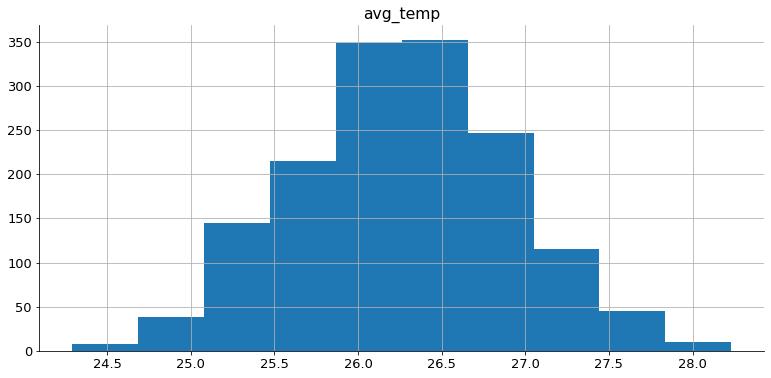

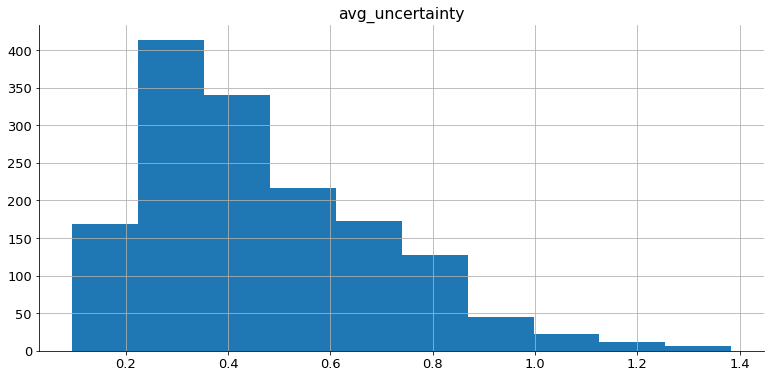

In [14]:
# viz distributions of cols
for col in df.columns:
    df[col].hist()
    plt.title(col)
    plt.show()

### Split

In [15]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

In [16]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index +1]
test = df[validate_end_index + 1:]

In [17]:
# check to see all rows used once
len(train) + len(validate) + len(test) == len(df)

True

**Wrangle Takeaways**
- gathered temps in Amazonas, Brazil
- drop unusable cols
- used data with continuous date range
- converted date col to datetime, set col as index, and sorted
- renamed cols
- grouped by index and aggregated by sum
- Initial dataframe: 645675 x 5
- Final dataframe: 1524 x 2 (not including datetime col)

## Explore

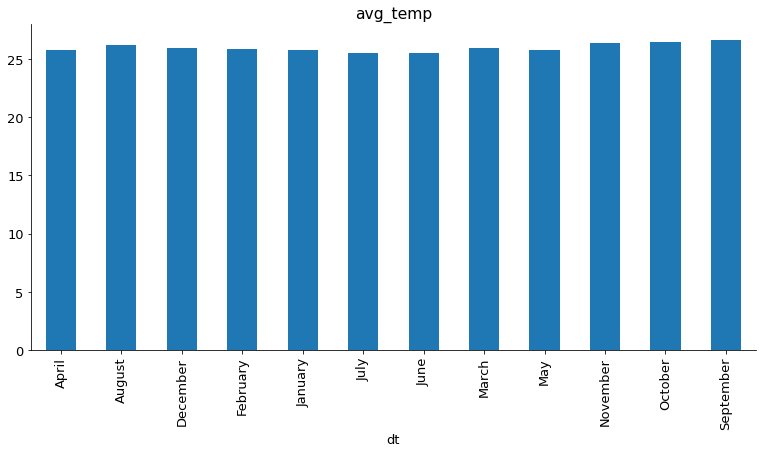

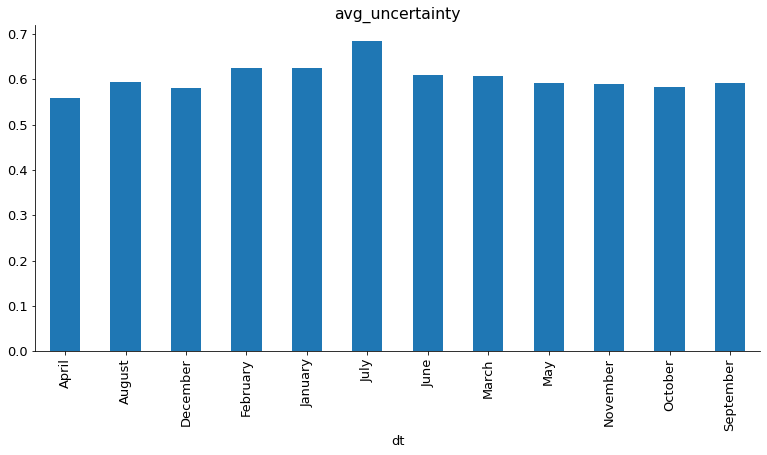

In [18]:
# viz average value for each month
for col in train.columns:
    train[col].groupby(train.index.month_name()).mean().plot.bar()
    plt.title(col)
    plt.show()

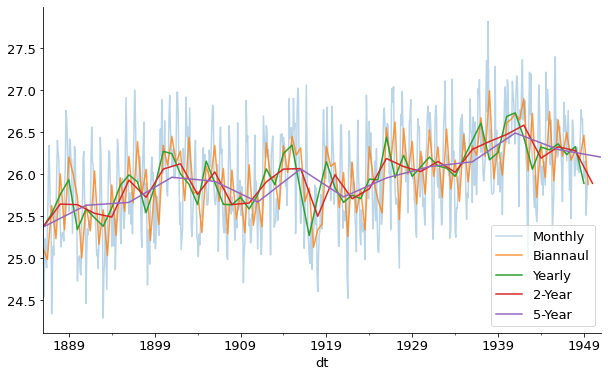

In [19]:
# viz multiple resamplings of average temps
plt.figure(figsize=(10,6))
ax = train.avg_temp.plot(alpha=.3, label='Monthly')
train.avg_temp.resample('6M').mean().plot(ax=ax, alpha=.8, label='Biannaul')
train.avg_temp.resample('Y').mean().plot(ax=ax, label='Yearly')
train.avg_temp.resample('2Y').mean().plot(ax=ax, label='2-Year')
train.avg_temp.resample('5Y').mean().plot(ax=ax, label='5-Year')

ax.legend()

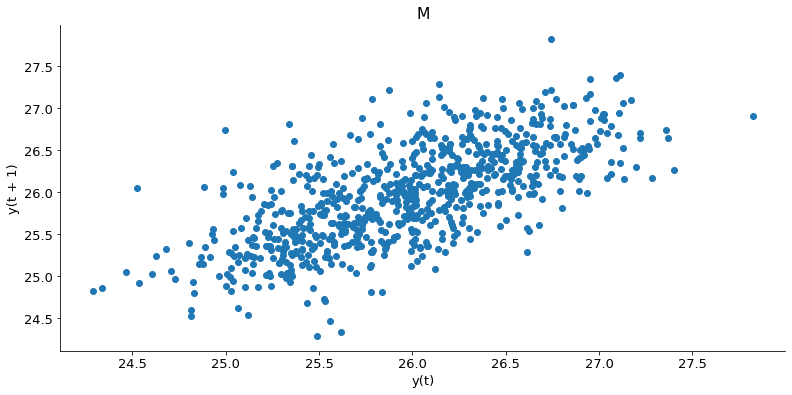

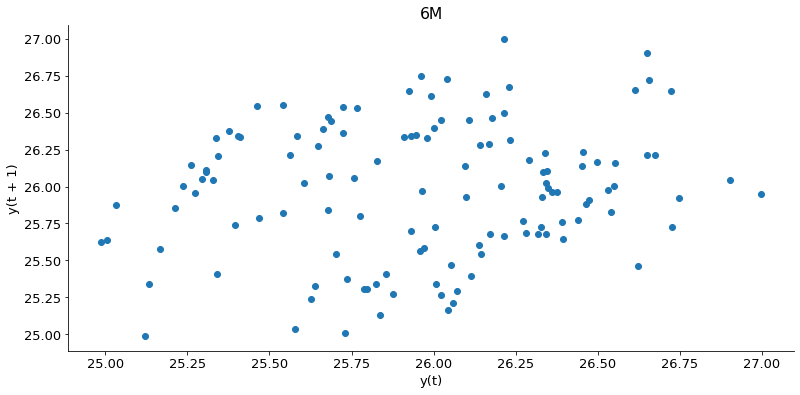

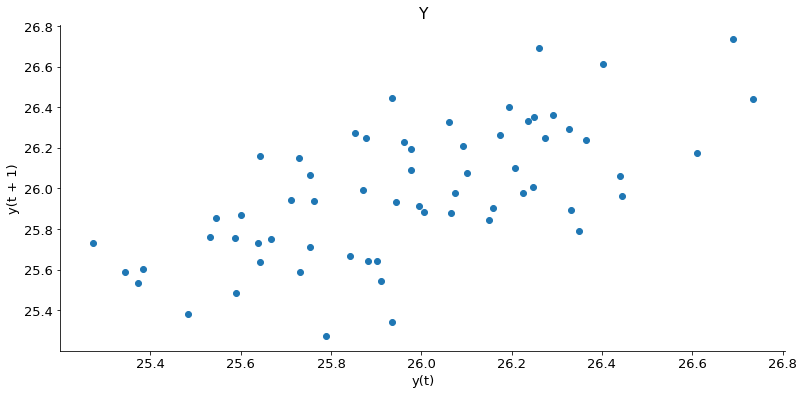

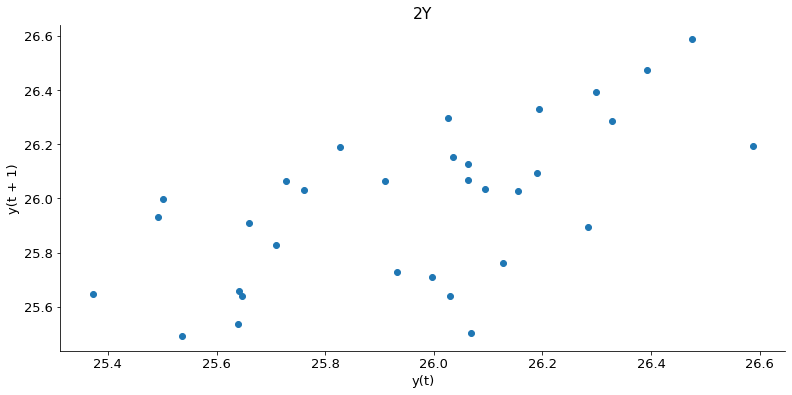

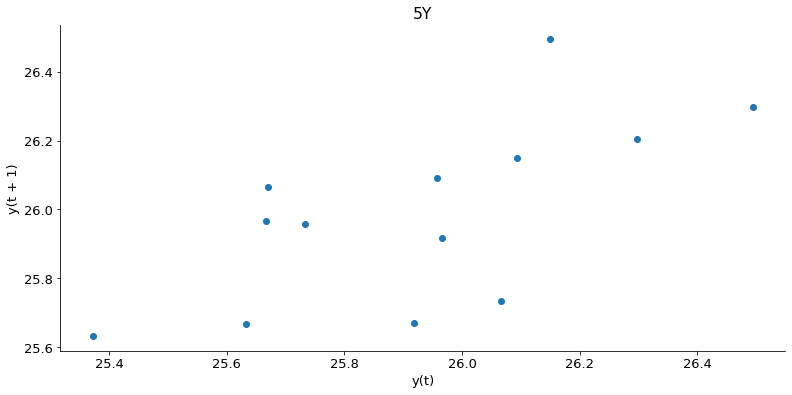

In [20]:
# plot lag plots of different resamplings
for interval in ['M', '6M', 'Y', '2Y', '5Y']:
    pd.plotting.lag_plot(train.avg_temp.resample(interval).mean(), 1)
    plt.title(interval)
    plt.show()

In [21]:
def autocorrelation(train, lag):
    """
    Function takes in df and lag value and returns correlation coefficient
    """
    return pd.concat([train.avg_temp, train.avg_temp.shift(lag)], axis=1).dropna().corr().iloc[0, 1]

------------------------------
------------------------------
------------------------------
M 1     0.688212
2     0.411926
3     0.225004
4     0.125989
5     0.146841
6     0.158936
7     0.107119
8     0.062121
9     0.115657
10    0.256399
dtype: float64


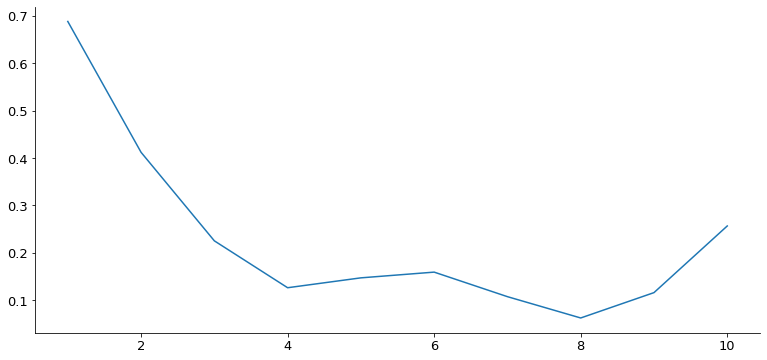

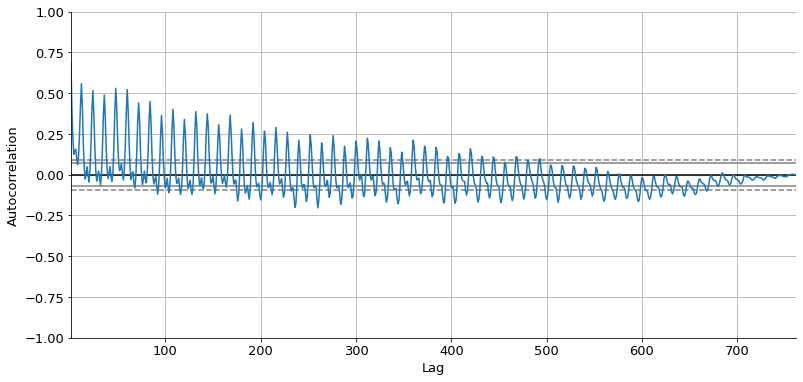

------------------------------


------------------------------
------------------------------
------------------------------
6M 1     0.159715
2     0.653551
3    -0.057965
4     0.577964
5    -0.078484
6     0.524962
7    -0.090704
8     0.618106
9    -0.012092
10    0.631095
dtype: float64


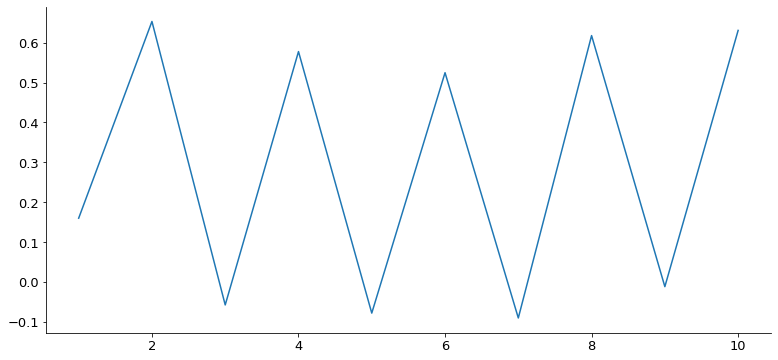

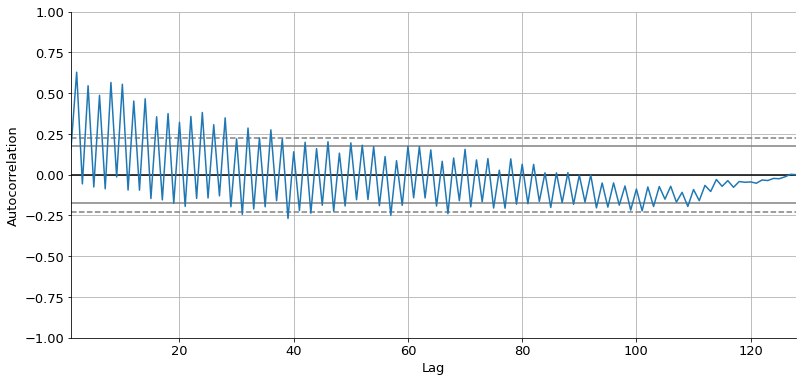

------------------------------


------------------------------
------------------------------
------------------------------
Y 1     0.646980
2     0.407338
3     0.384797
4     0.512868
5     0.467452
6     0.409120
7     0.312403
8     0.203290
9     0.233073
10    0.277722
dtype: float64


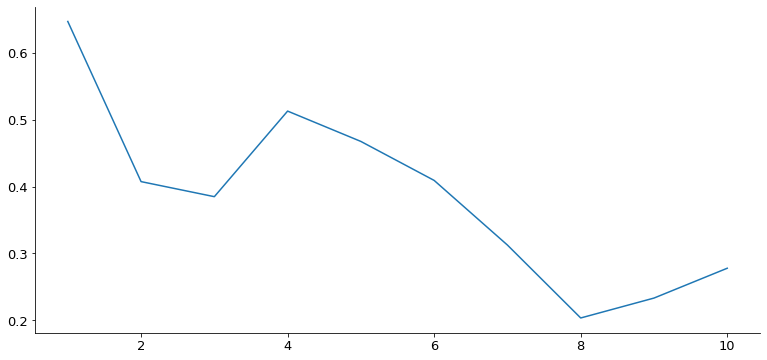

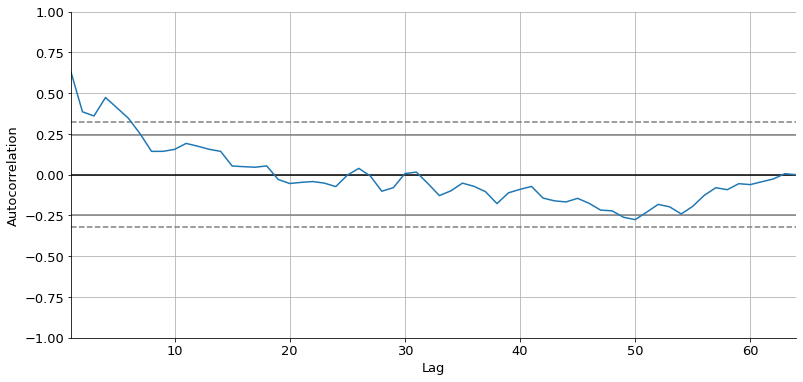

------------------------------


------------------------------
------------------------------
------------------------------
2Y 1     0.617550
2     0.580892
3     0.543434
4     0.303330
5     0.392935
6     0.367813
7     0.374647
8     0.267619
9     0.155166
10    0.181781
dtype: float64


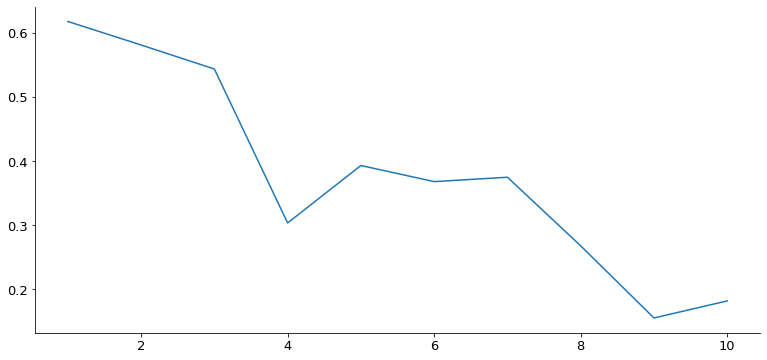

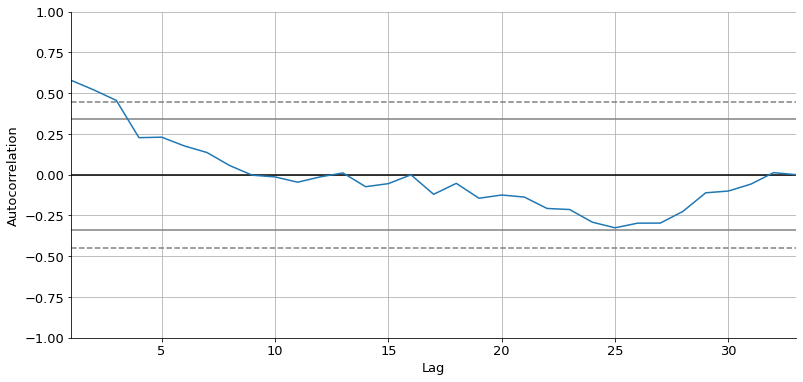

------------------------------


------------------------------
------------------------------
------------------------------
5Y 1     0.664401
2     0.632191
3     0.499267
4     0.250630
5     0.680964
6     0.293740
7     0.713404
8     0.948108
9     0.352632
10    0.081469
dtype: float64


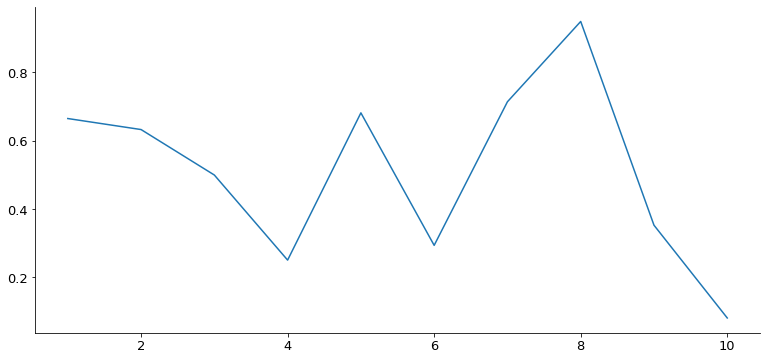

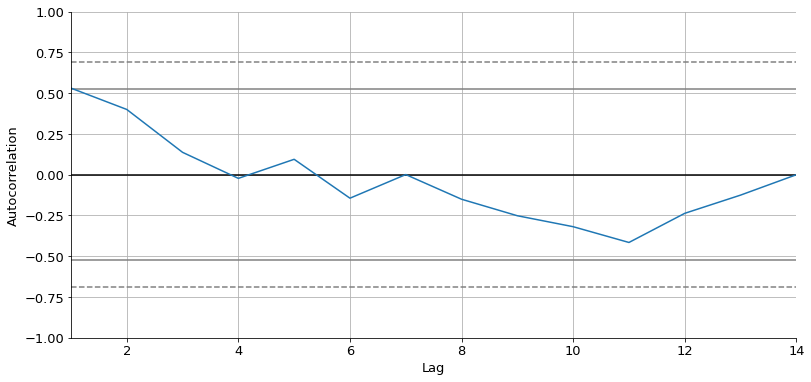

------------------------------




In [22]:
# get correlation coefficients for multiple lag values
# viz different autocorrelation plots
for interval in ['M', '6M', 'Y', '2Y', '5Y']:
    print('------------------------------')
    print('------------------------------')
    print('------------------------------')
    autocorr = pd.Series({lag: autocorrelation(train.resample(interval).mean(), lag) for lag in range(1, 11)})
    print(interval, autocorr)
    autocorr.plot()
    plt.show()
    pd.plotting.autocorrelation_plot(train.avg_temp.resample(interval).mean())
    plt.show()
    print('------------------------------')
    print('\n')

|-------------------| M |-------------------| 



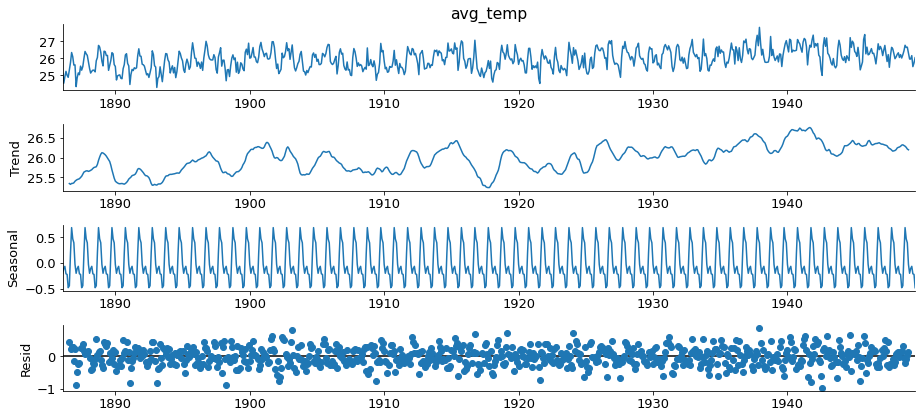

|-------------------| 3M |-------------------| 



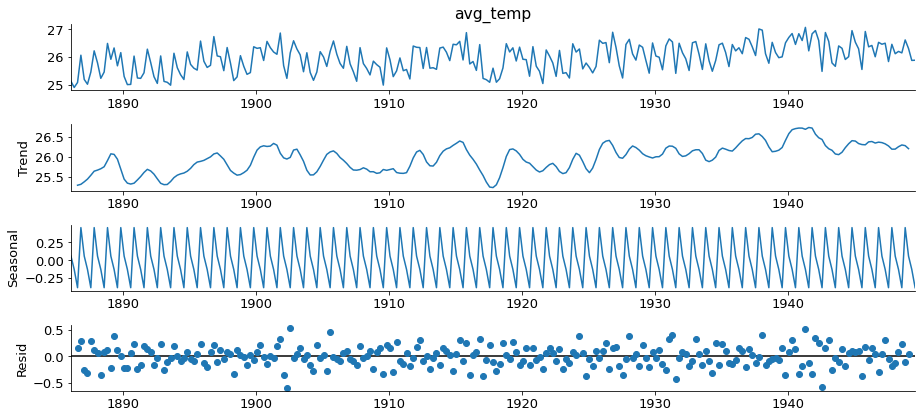

|-------------------| 6M |-------------------| 



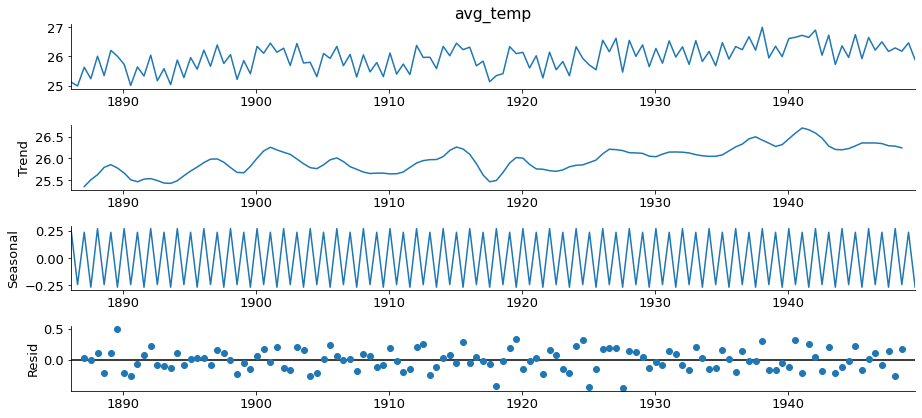

|-------------------| Y |-------------------| 



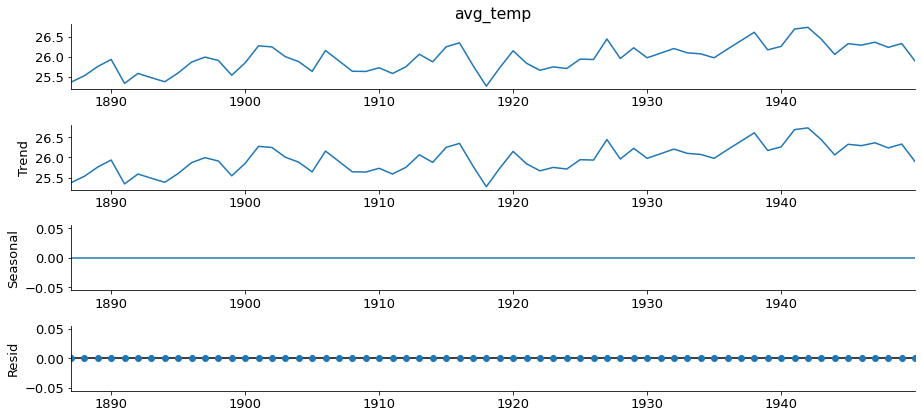

|-------------------| 5Y |-------------------| 



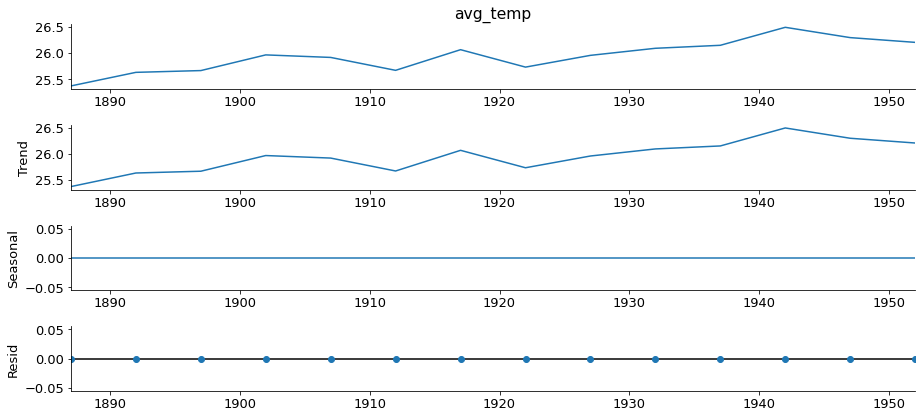

|-------------------| 10Y |-------------------| 



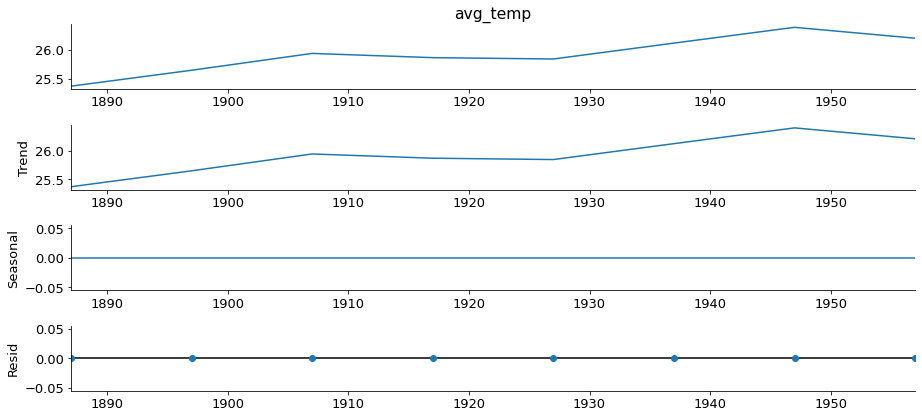

In [23]:
# seasonal decomposition plots for different intervals
for interval in ['M', '3M', '6M', 'Y', '5Y', '10Y']:
    print('|-------------------|', interval, '|-------------------|', '\n')
    _ = sm.tsa.seasonal_decompose(train['avg_temp'].resample(interval).mean()).plot()
    plt.show()

#### Explore Takeaways

- Temperature does not seem to vary too much which makes sense for this location
- Average temperature seems to be slowly increasing

---
## Forecast

In [24]:
def plot_samples(target_var):
    """
    Function plots target variable from train, validate, and test datasets
    """
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)
    plt.tight_layout()

    
def evaluate(target_var):
    """
    the evaluate function takes in actual and predicted values in validate,
    computes mean_squared_error and takes sqrt
    Returns rmse as an integer
    """
    rmse = sqrt(mean_squared_error(validate[target_var], yhat_df[target_var]))
    return rmse


def plot_and_eval(target_var):
    """
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    """
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()
    

def append_eval_df(model_type, target_var):
    """
    Function takes in model_type and target_var as strings and runs evaluate function
    to compute rmse, and appends to the dataframe a row with the model type, target var and rmse.
    Returns new dataframe.
    """
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    """
    Function creates dataframe to hold predictions on validate dataset
    """
    yhat_df = pd.DataFrame({'avg_temp': [temp],
                            'avg_uncertainty': [uncert],
                           }, index = validate.index)
    return yhat_df

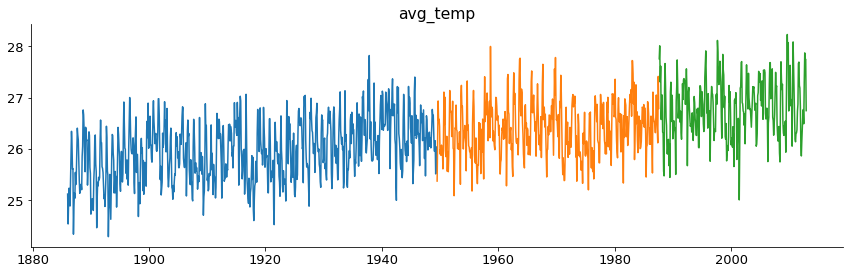

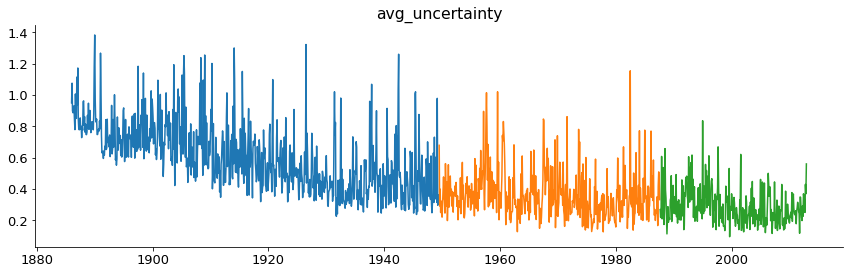

In [25]:
# viz all datasets as continuous graph
for col in train.columns:
    plot_samples(col)

In [26]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

# check out the data frame
eval_df

,model_type,target_var,rmse


### Simple Average

In [27]:
# create vars that hold average of each col
temp = train.avg_temp.mean()
uncert = train.avg_uncertainty.mean()

In [28]:
# predict
yhat_df = make_predictions()
yhat_df.head(2)

,avg_temp,avg_uncertainty
dt,,
1949-07-01,25.970178,0.603283
1949-08-01,25.970178,0.603283


avg_temp -- RMSE: 0.6626


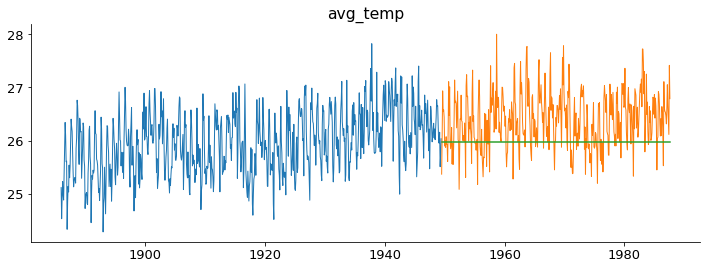

avg_uncertainty -- RMSE: 0.2848


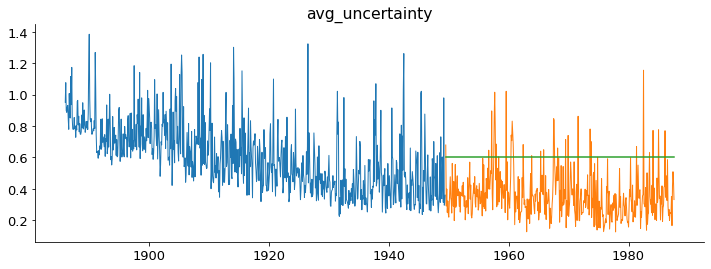

In [29]:
# viz predictions
for col in train.columns:
    plot_and_eval(col)

In [30]:
# store metrics in df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_avg', target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_avg,avg_temp,0.662644
1,simple_avg,avg_uncertainty,0.284774


### Moving Average

In [31]:
# create vars to hold predictions
temp = train['avg_temp'].rolling(3).mean().iloc[-1]
uncert = train['avg_uncertainty'].rolling(3).mean().iloc[-1]

# make the predictions
yhat_df = make_predictions()

# store predictions
model_type = '3-Month moving average'
eval_df = append_eval_df(model_type = model_type,
                         target_var = 'avg_temp'
                        )
eval_df = append_eval_df(model_type = model_type,
                         target_var = 'avg_uncertainty'
                        )

avg_temp -- RMSE: 0.8114


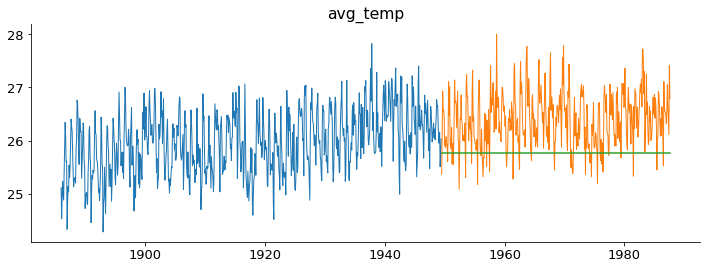

avg_uncertainty -- RMSE: 0.1575


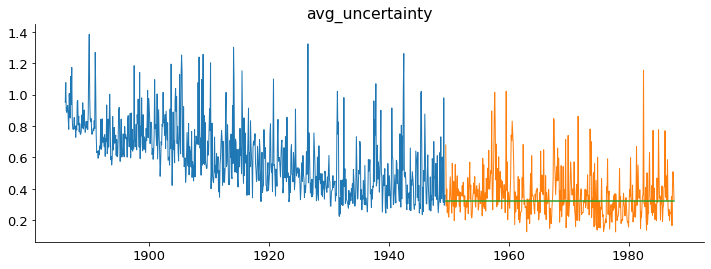

In [32]:
# viz predictions
for col in train.columns:
    plot_and_eval(col)

In [33]:
# metrics dataframe
eval_df

,model_type,target_var,rmse
0,simple_avg,avg_temp,0.662644
1,simple_avg,avg_uncertainty,0.284774
2,3-Month moving average,avg_temp,0.811416
3,3-Month moving average,avg_uncertainty,0.157495


In [34]:
# create for-loop that tests for multiple time periods
periods = range(6, 61, 6)

for p in periods:
    temp = train['avg_temp'].rolling(p).mean().iloc[-1]
    uncert = train['avg_uncertainty'].rolling(p).mean().iloc[-1]
    yhat_df = make_predictions()
    model_type = str(int(p)) + '-M moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'avg_temp'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'avg_uncertainty'
                            )
eval_df

,model_type,target_var,rmse
0,simple_avg,avg_temp,0.662644
1,simple_avg,avg_uncertainty,0.284774
2,3-Month moving average,avg_temp,0.811416
3,3-Month moving average,avg_uncertainty,0.157495
4,6-M moving average,avg_temp,0.713305
5,6-M moving average,avg_uncertainty,0.178731
6,12-M moving average,avg_temp,0.545892
7,12-M moving average,avg_uncertainty,0.189066
8,18-M moving average,avg_temp,0.551124
9,18-M moving average,avg_uncertainty,0.169567


In [35]:
# get the min rmse for each variable
min_rmse_avg_temp = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_avg_uncert = eval_df.groupby('target_var')['rmse'].min()[1]

In [36]:
# filter only the rows that match those rmse to find out 
# determine which time periods perform the best
eval_df[((eval_df.rmse == min_rmse_avg_temp) | 
         (eval_df.rmse == min_rmse_avg_uncert)
        )]

,model_type,target_var,rmse
3,3-Month moving average,avg_uncertainty,0.157495
22,60-M moving average,avg_temp,0.519097


In [37]:
# filter metric dataframe
eval_df = pd.concat([eval_df[:4], eval_df[22:24]])
eval_df

,model_type,target_var,rmse
0,simple_avg,avg_temp,0.662644
1,simple_avg,avg_uncertainty,0.284774
2,3-Month moving average,avg_temp,0.811416
3,3-Month moving average,avg_uncertainty,0.157495
22,60-M moving average,avg_temp,0.519097
23,60-M moving average,avg_uncertainty,0.179414


### Holt's Linear Trend

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


avg_temp -- RMSE: 0.5079


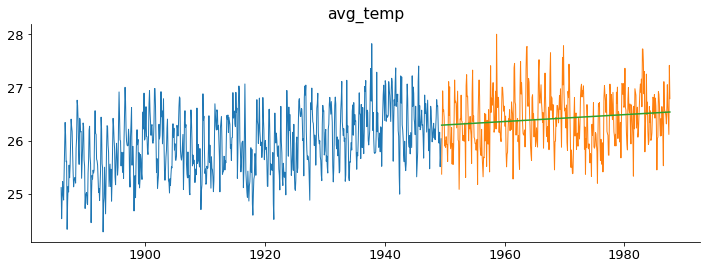

avg_uncertainty -- RMSE: 0.1513


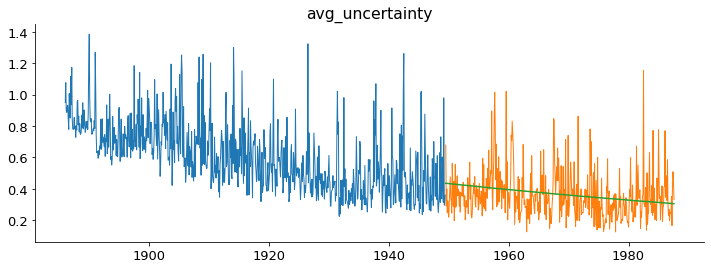

In [38]:
# Use different hyperparameters for each col and make predictions for each col
for col in train.columns:
    if col == 'avg_temp':
        # create and fit
        model = Holt(train[col], 
                     exponential=False)
        model = model.fit(smoothing_level=.03,
             smoothing_slope=.005,
             optimized=True)
        # predict forecast providing start and end date
        yhat = model.predict(start = yhat_df.index[0],
                            end = yhat_df.index[-1])
        yhat_df[col] = yhat
    else:
        model = Holt(train[col], 
                     exponential=True)
        # fit the model
        model = model.fit(smoothing_level=.2,
                          smoothing_slope=.001,
                          optimized=True)
        # predict forecast providing start and end date
        yhat = model.predict(start = yhat_df.index[0],
                            end = yhat_df.index[-1])
        yhat_df[col] = yhat
        
# store metrics and viz predictions
for col in train.columns:
    eval_df = append_eval_df(model_type='Holts', target_var = col)
    plot_and_eval(target_var = col)

In [39]:
eval_df

,model_type,target_var,rmse
0,simple_avg,avg_temp,0.662644
1,simple_avg,avg_uncertainty,0.284774
2,3-Month moving average,avg_temp,0.811416
3,3-Month moving average,avg_uncertainty,0.157495
4,60-M moving average,avg_temp,0.519097
5,60-M moving average,avg_uncertainty,0.179414
6,Holts,avg_temp,0.507944
7,Holts,avg_uncertainty,0.151342


### Predict Based on Previous Cycle

In [40]:
# reshape the split datsets
train = df[:'1971']
validate = df['1972' : '1991']
test = df['1992' :]

In [41]:
# take the values for month from 1947 - 1970 and subtract the average 4-year temp
# difference will be our forecast
yhat_df = train['1952' :] - train.diff(48).mean()

# set yhat_df index to index of validate
yhat_df = yhat_df.set_index(validate.index)

yhat_df.head()

,avg_temp,avg_uncertainty
dt,,
1972-01-01,26.204951,0.398258
1972-02-01,26.541951,0.380258
1972-03-01,26.893951,0.387258
1972-04-01,25.977951,0.443258
1972-05-01,25.953951,0.376258


In [42]:
# store predictions
for col in train.columns:
    eval_df = append_eval_df('4Y', col)
eval_df

,model_type,target_var,rmse
0,simple_avg,avg_temp,0.662644
1,simple_avg,avg_uncertainty,0.284774
2,3-Month moving average,avg_temp,0.811416
3,3-Month moving average,avg_uncertainty,0.157495
4,60-M moving average,avg_temp,0.519097
5,60-M moving average,avg_uncertainty,0.179414
6,Holts,avg_temp,0.507944
7,Holts,avg_uncertainty,0.151342
8,4Y,avg_temp,0.594477
9,4Y,avg_uncertainty,0.228436


avg_temp -- RMSE: 0.5945


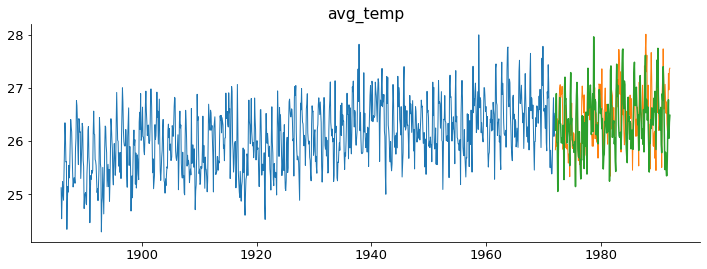

avg_uncertainty -- RMSE: 0.2284


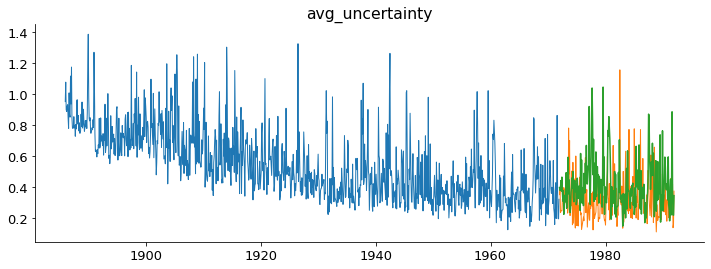

In [43]:
# viz predictions
for col in train.columns:
    plot_and_eval(col)

**Forecast Takeaways**
- No model had a rmse that was less than 0.5
- 5-year and Holt's models performed similary with an rmse of ~0.51
- We will see which of the two models performed the best

## Conclusion

In [44]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
6,Holts,avg_temp,0.507944
7,Holts,avg_uncertainty,0.151342


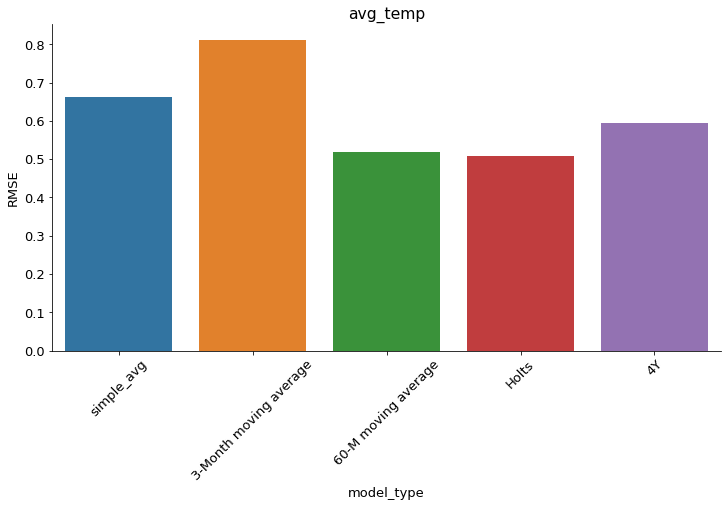

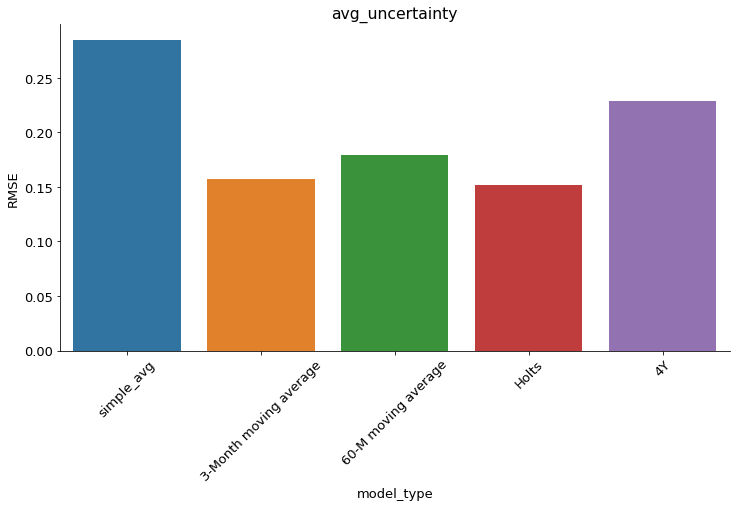

In [45]:
# viz models' performances
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

Holt's Linear Trend performed the best so we will use this model and test on our out-of-sample-data.

In [46]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index +1]
test = df[validate_end_index + 1:]

In [47]:
# prepare dataframe to hold predictions
temp = []
uncert = []

yhat_df = pd.DataFrame({'avg_temp': [temp],
                        'avg_uncertainty': [uncert],
                       }, index = test.index)

In [48]:
# test model on test dataset
for col in train.columns:
    if col == 'avg_temp':
        # create and fit
        model = Holt(train[col], 
                     exponential=False)
        model = model.fit(smoothing_level=.03,
             smoothing_slope=.005,
             optimized=True)
        # predict forecast providing start and end date
        yhat = model.predict(start = yhat_df.index[0],
                            end = yhat_df.index[-1])
        yhat_df[col] = yhat
    else:
        model = Holt(train[col], 
                     exponential=True)
        # fit the model
        model = model.fit(smoothing_level=.2,
                          smoothing_slope=.001,
                          optimized=True)
        # predict forecast providing start and end date
        yhat = model.predict(start = yhat_df.index[0],
                            end = yhat_df.index[-1])
        yhat_df[col] = yhat

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [49]:
def plot_and_eval(target_var):
    """
    Function to plot all datasets and predictions
    """
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

In [50]:
# metrics for test predictions
rmse_temp = round(sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'])), 5)
rmse_uncertainty = round(sqrt(mean_squared_error(test['avg_uncertainty'], yhat_df['avg_uncertainty'])), 5)

rmse - avg_temp:  0.58607
rmse - avg_uncertainty:  0.11292


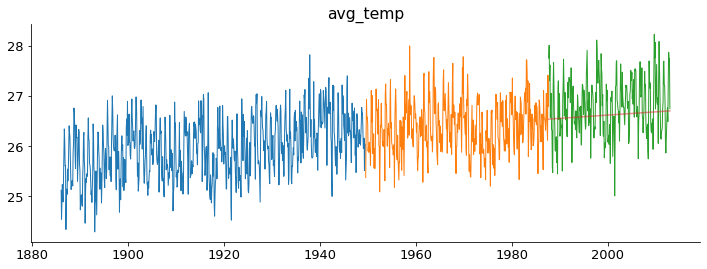

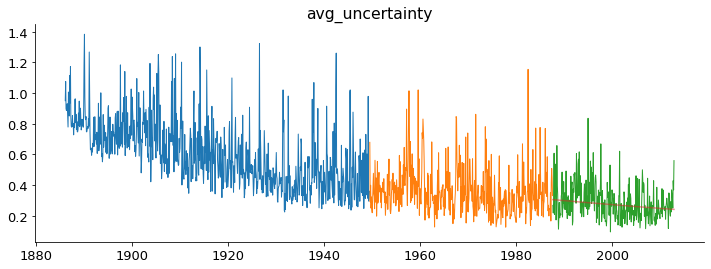

In [51]:
# prints metrics and plots cols and respective predictions
print("rmse - avg_temp: ", rmse_temp)
print("rmse - avg_uncertainty: ", rmse_uncertainty)

for col in train.columns:
    plot_and_eval(col)

In [52]:
# get r-squared score
for col in train.columns:
    print(f'{col} r2 = {r2_score(test[col], yhat_df[col])}')

avg_temp r2 = -0.09205677708454552
avg_uncertainty r2 = 0.03400771703656735


Wow that's bad.

**Final Takeaways**
- Moving Average (3-month and 5-year) and Holts' Linear Trend performed similarly
- Holt's Linear Trend performed the best overall
- Ultimately Holt's Linear Trend did not perform well

### Given More Time...
- explore previous cycles with different samplings
- resample whole report to get a less granular trends
- look at surrounding areas to see if temperature fluctuations match with Amazonas'